In [13]:
# --- 0: Libraries ---
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.metrics import (
    roc_auc_score, confusion_matrix, classification_report, RocCurveDisplay
)
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import precision_score, recall_score, f1_score
import warnings
warnings.filterwarnings('ignore')



### 1. Load and clean data

In [14]:
df = pd.read_csv('/Users/sunny/Applied Analytics/2025 Fall/Capstone/cleaned_sales.csv')

# Standardize column names
df.columns = (
    df.columns.str.strip()
    .str.lower()
    .str.replace('.', '_', regex=False)
    .str.replace(' ', '_', regex=False)
)

cols = [
    'email', 'financial_status', 'paid_at', 'created_at', 'accepts_marketing',
    'total', 'discount_code', 'discount_amount', 'lineitem_quantity',
    'lineitem_price', 'lineitem_compare_at_price', 'risk_level', 'payment_method',
    'shipping_city', 'shipping_province', 'shipping_country', 'source', 'id'
]
df = df[cols]



### 2. Parse Dates & Filter Timeframe

In [15]:
df['paid_at'] = pd.to_datetime(df['paid_at'], errors='coerce')
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

df['order_date'] = df['paid_at'].combine_first(df['created_at'])

df = df[
    (df['order_date'] >= '2024-07-01') &
    (df['order_date'] <= '2025-09-30')
]


### 3. Aggregate to Customer-Level

In [16]:
def dominant_mode(series):
    if series.dropna().empty:
        return np.nan
    return series.mode().iloc[0]

cust = (
    df.groupby('email', dropna=True)
    .agg(
        n_orders=('id', 'nunique'),
        first_purchase=('order_date', 'min'),
        last_purchase=('order_date', 'max'),
        avg_spend=('total', 'mean'),
        total_spend=('total', 'sum'),
        avg_items=('lineitem_quantity', 'mean'),
        marketing_optin=('accepts_marketing', lambda x: int((x == 'yes').any())),
        n_discounts=('discount_code', lambda x: x.notna().sum()),
        avg_discount=('discount_amount', 'mean'),
    )
    .reset_index()
)




### 4. Label Churn + Derived Features

In [17]:
cutoff_date = pd.to_datetime('2025-09-30')

cust['days_since_last'] = (cutoff_date - cust['last_purchase']).dt.days
cust['churned'] = np.where(cust['days_since_last'] > 180, 'churned', 'retained')


# Derived numeric features
cust['avg_gap_days'] = np.where(
    cust['n_orders'] > 1,
    (cust['last_purchase'] - cust['first_purchase']).dt.days / (cust['n_orders'] - 1),
    np.nan
)



### 5. Train / Test Split

In [18]:
train, test = train_test_split(cust, test_size=0.2, random_state=42, stratify=cust['churned'])


### 6. XGBoost Model

In [19]:
num_features = [
    'avg_spend', 'total_spend', 'avg_items', 'marketing_optin',
    'n_discounts', 'avg_discount', 'avg_gap_days'
]

numeric_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# ⚠️ If you have categorical vars, define them here (currently not used)
cat_features = []
categorical_transformer = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

preprocessor = ColumnTransformer([
    ('num', numeric_transformer, num_features)
])

# -------------------------
# 2️⃣ Build and fit XGBoost model
# -------------------------
xgb_model = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', XGBClassifier(
        n_estimators=1000,
        learning_rate=0.05,
        max_depth=6,
        min_child_weight=5,
        gamma=1,
        subsample=0.8,
        colsample_bytree=0.8,
        eval_metric='auc',
        random_state=42
    ))
])

from sklearn.model_selection import train_test_split

# target column is 'churned' (1 = churned, 0 = retained)
X = cust[num_features]
y = cust['churned'].map({'retained': 0, 'churned': 1})   # convert to numeric labels

# 80/20 train-test split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

xgb_model.fit(X_train, y_train)



,steps,"[('preprocessor', ...), ('classifier', ...)]"
,transform_input,None
,memory,None
,verbose,False
,transformers,"[('num', ...)]"
,remainder,'drop'
,sparse_threshold,0.3
,n_jobs,None
,transformer_weights,None
,verbose,False
,verbose_feature_names_out,True


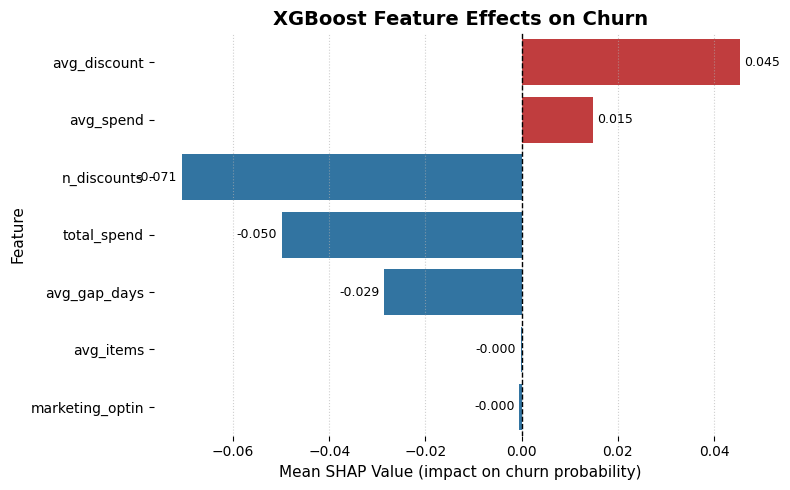

In [23]:
import shap

model = xgb_model.named_steps['classifier']
X_train_transformed = xgb_model.named_steps['preprocessor'].transform(X_train)

# 2️⃣ Create SHAP explainer
explainer = shap.Explainer(model)
shap_values = explainer(X_train_transformed)

# 3️⃣ Compute mean SHAP value (directional impact) per feature
shap_df = pd.DataFrame({
    'Feature': num_features,
    'Mean_SHAP': shap_values.values.mean(axis=0),
    'Abs_SHAP': abs(shap_values.values).mean(axis=0)
})

# 4️⃣ Sort by absolute effect strength (top 10)
top10 = shap_df.sort_values('Abs_SHAP', ascending=False).head(10)

# 5️⃣ Plot with direction (positive = increases churn, negative = decreases churn)
plt.figure(figsize=(8, 5))
sns.barplot(
    data=top10,
    x='Mean_SHAP',
    y='Feature',
    palette=['#d62728' if c > 0 else '#1f77b4' for c in top10['Mean_SHAP']]
)

plt.title("XGBoost Feature Effects on Churn", fontsize=14, weight='bold')
plt.xlabel("Mean SHAP Value (impact on churn probability)", fontsize=11)
plt.ylabel("Feature", fontsize=11)
plt.axvline(0, color='black', linestyle='--', linewidth=1)
plt.grid(axis='x', linestyle=':', alpha=0.6)
sns.despine(left=True, bottom=True)

# Add labels to bars
for index, value in enumerate(top10['Mean_SHAP']):
    plt.text(
        value + (0.001 if value > 0 else -0.001),
        index,
        f"{value:.3f}",
        va='center',
        ha='left' if value > 0 else 'right',
        fontsize=9
    )

plt.tight_layout()
plt.show()


### 7. Model Evaluation

In [21]:
# --- Evaluation ---
y_pred_xgb = xgb_model.predict(X_test)
y_proba_xgb = xgb_model.predict_proba(X_test)[:, 1]

# AUC and classification report
print("🔥 XGBoost AUC:", round(roc_auc_score(y_test, y_proba_xgb), 3))
print(confusion_matrix(y_test, y_pred_xgb))
print(classification_report(y_test, y_pred_xgb, target_names=['retained (0)', 'churned (1)']))

# Metrics for each class
print("Precision (retained):", precision_score(y_test, y_pred_xgb, pos_label=0))
print("Recall (retained):", recall_score(y_test, y_pred_xgb, pos_label=0))
print("F1 (retained):", f1_score(y_test, y_pred_xgb, pos_label=0))

print("Precision (churned):", precision_score(y_test, y_pred_xgb, pos_label=1))
print("Recall (churned):", recall_score(y_test, y_pred_xgb, pos_label=1))
print("F1 (churned):", f1_score(y_test, y_pred_xgb, pos_label=1))



🔥 XGBoost AUC: 0.763
[[2553 1337]
 [1109 2601]]
              precision    recall  f1-score   support

retained (0)       0.70      0.66      0.68      3890
 churned (1)       0.66      0.70      0.68      3710

    accuracy                           0.68      7600
   macro avg       0.68      0.68      0.68      7600
weighted avg       0.68      0.68      0.68      7600

Precision (retained): 0.6971600218459858
Recall (retained): 0.6562982005141388
F1 (retained): 0.6761122881355932
Precision (churned): 0.6604875571356018
Recall (churned): 0.701078167115903
F1 (churned): 0.6801778242677824


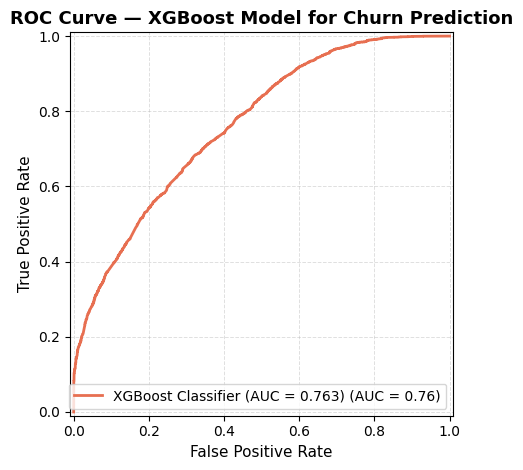

In [22]:
from sklearn.metrics import RocCurveDisplay, roc_auc_score
import matplotlib.pyplot as plt

# --- Extract preprocessed test data and classifier ---
X_test_transformed = xgb_model.named_steps['preprocessor'].transform(X_test)
xgb_clf = xgb_model.named_steps['classifier']

# --- Predict probabilities for ROC curve ---
y_pred_proba = xgb_clf.predict_proba(X_test_transformed)[:, 1]
auc_score = roc_auc_score(y_test, y_pred_proba)

# --- Plot ROC curve ---
RocCurveDisplay.from_predictions(
    y_test,
    y_pred_proba,
    name=f'XGBoost Classifier (AUC = {auc_score:.3f})',
    color='#E76F51',
    linewidth=2
)

# --- Styling ---
plt.title('ROC Curve — XGBoost Model for Churn Prediction', fontsize=13, weight='bold')
plt.xlabel('False Positive Rate', fontsize=11)
plt.ylabel('True Positive Rate', fontsize=11)
plt.grid(alpha=0.4, linestyle='--', linewidth=0.7)
plt.tight_layout()
plt.show()
